## Opis problemu

Znajdź dowolny zbiór danych (dozwolone języki: angielski, hiszpański, polski, szwedzki) (poza IMDB oraz zbiorami wykorzystywanymi na zajęciach) do analizy sentymentu.
Zbiór może mieć 2 lub 3 klasy.

Następnie:
1. Oczyść dane i zaprezentuj rozkład klas
2. Zbuduj model analizy sentymenu:
  - z wykorzystaniem sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN
  - z wykorzystaniem sieci CNN
  - z podstawiemiem pre-trained word embeddingów
  - z fine-tuningiem modelu języka (poza podstawowym BERTem)

3. Stwórz funkcję, która będzie korzystała z wytrenowanego modelu i zwracała wynik dla przekazanego pojedynczego zdania (zdań) w postaci komunikatu informującego użytkownika, czy tekst jest nacechowany negatywnie, pozytywnie (czy neutralnie w przypadku 3 klas).

4. Gotowe rozwiązanie zamieść na GitHubie z README. W README zawrzyj: informacje o danych - ich pochodzenie, oraz opis wybranego modelu i instrukcje korzystania z plików.
5. W assigmnencie w Teamsach wrzuć link do repo z rozwiązaniem. W przypadku prywatnego repo upewnij się, że będzie ono widoczne dla `dwnuk@pjwstk.edu.pl`.

**TERMIN**: jak w Teamsach

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Data set
# Sentiment140 dataset with 1.6 million tweets z Kaggle


DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('/content/drive/MyDrive/Kopia training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

In [5]:
# Zostawiam tylko potrzebne kolumny
dataset = dataset[['sentiment','text']]
dataset.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [6]:
dataset['sentiment'].unique()

array([0, 4])

In [7]:
# Zamieniam 4 na 1 z kolumny 'sentiment' dla większej czytelności danych
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

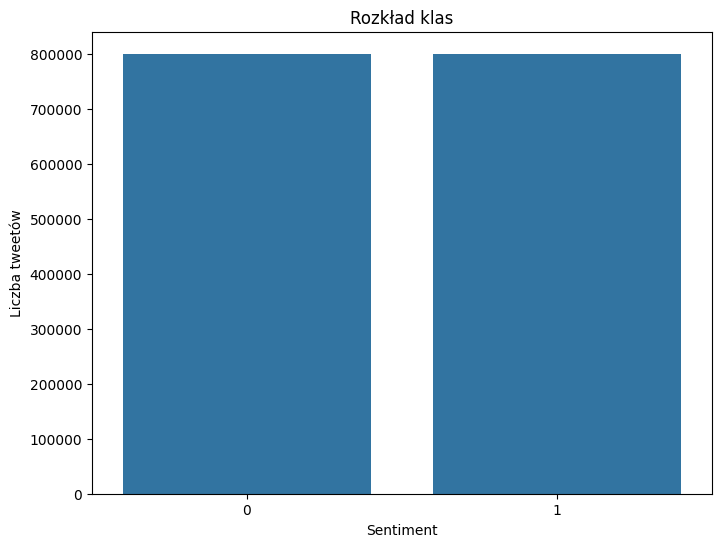

In [8]:
# Prezentacja rozkładu klas
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=dataset)
plt.title('Rozkład klas')
plt.xlabel('Sentiment')
plt.ylabel('Liczba tweetów')
plt.show()

In [9]:
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

In [10]:
# słownik mapujący emojis z ich znaczeniem
# zbiór danych pochodzi z twittera dlatego emoijs mogą w nim występować


emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Set ze stopwords

stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [11]:
import re
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [12]:
def preprocess(textdata):
    processedText = []

    wordLemm = WordNetLemmatizer()

    # regex
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    for tweet in textdata:
        # zmiana na małe litery
        tweet = tweet.lower()

        # zamieniam URls na 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # zmieniam emojis z moim słownikiem emojis
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
        # zmiana @Użytkownik na 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)
        # usuwam wszystkie niealfabetyczne znaki
        tweet = re.sub(alphaPattern, " ", tweet)
        # jak są 3 lub więcej liter to zmieniam na dwa np. coooool na cool
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            #if word not in stopwordlist:
            if len(word)>1:
                #
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')

        processedText.append(tweetwords)

    return processedText

In [13]:
processedtext = preprocess(text)


In [14]:
from wordcloud import WordCloud


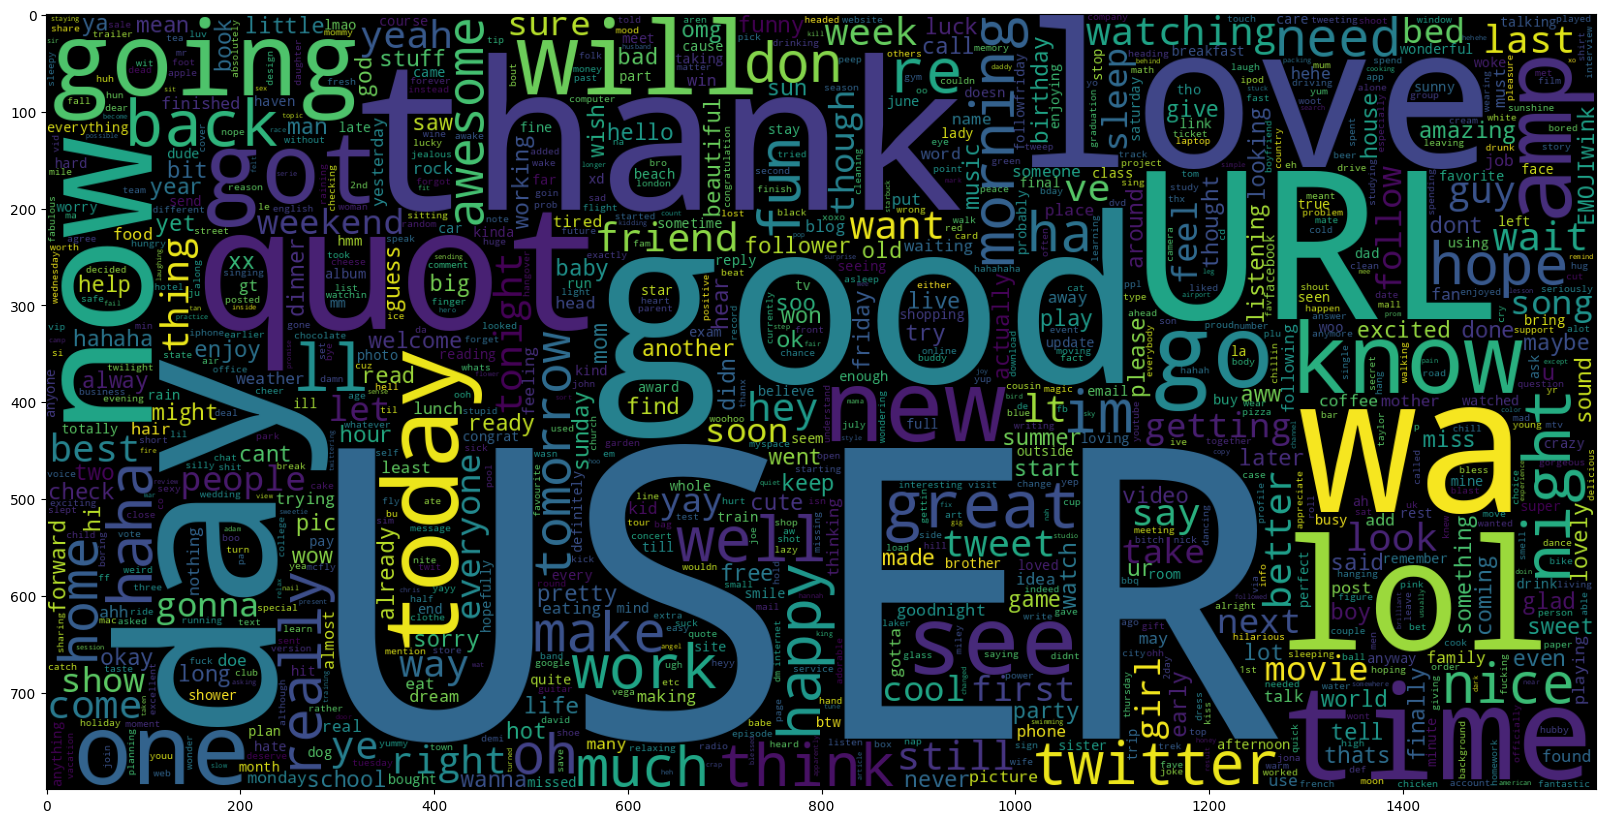

In [15]:
# Chmura dla pozytywnych tweetów
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

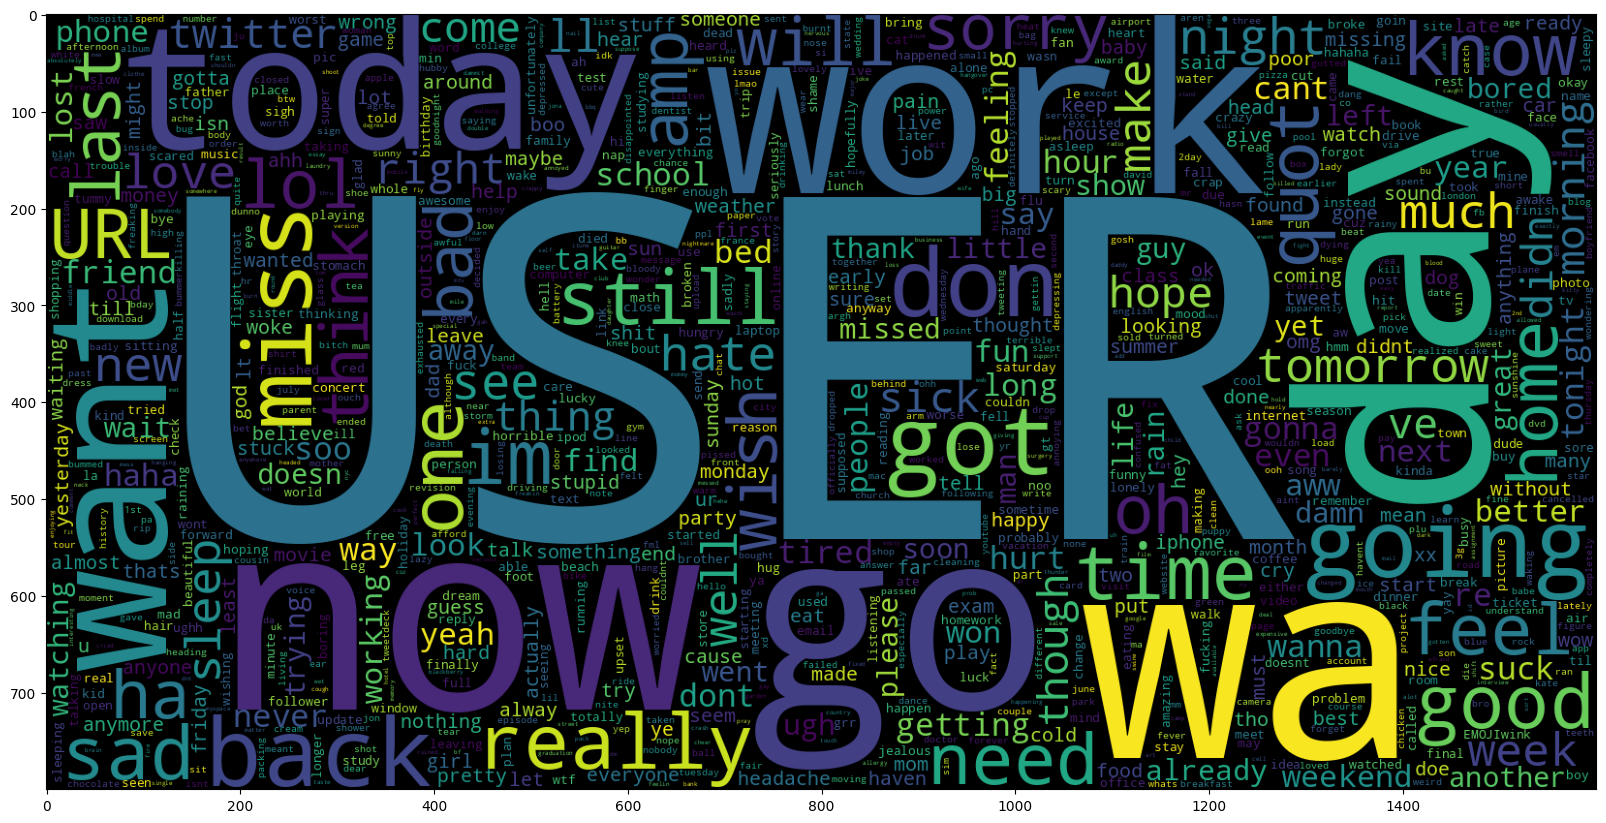

In [16]:
# Chmura negatywnych
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# tworzę tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(processedtext)

sequences = tokenizer.texts_to_sequences(processedtext)

padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split

labels = np.array(sentiment)

# podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

## 2. Model


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense


In [28]:
embedding_dim = 50

cnn_model = Sequential([
    Embedding(input_dim=10000, output_dim=embedding_dim, input_length=100),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [29]:
cnn_model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))


Epoch 1/5
40000/40000 [==============================] - 207s 5ms/step - loss: 0.4137 - accuracy: 0.8098 - val_loss: 0.3928 - val_accuracy: 0.8216
Epoch 2/5
40000/40000 [==============================] - 193s 5ms/step - loss: 0.3778 - accuracy: 0.8305 - val_loss: 0.3897 - val_accuracy: 0.8227
Epoch 3/5
40000/40000 [==============================] - 188s 5ms/step - loss: 0.3576 - accuracy: 0.8418 - val_loss: 0.4070 - val_accuracy: 0.8203
Epoch 4/5
40000/40000 [==============================] - 191s 5ms/step - loss: 0.3397 - accuracy: 0.8517 - val_loss: 0.4013 - val_accuracy: 0.8196
Epoch 5/5
40000/40000 [==============================] - 193s 5ms/step - loss: 0.3235 - accuracy: 0.8604 - val_loss: 0.4148 - val_accuracy: 0.8143


10000/10000 [==============================] - 19s 2ms/step


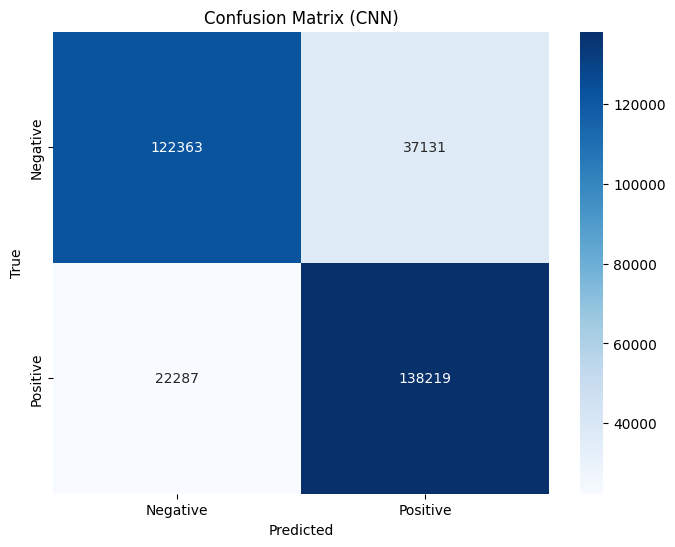

In [30]:
y_pred_cnn_probs = cnn_model.predict(X_test)
y_pred_cnn = (y_pred_cnn_probs > 0.5).astype(int)

# macierz pomyłek
cm_cnn = confusion_matrix(y_test, y_pred_cnn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix (CNN)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 3. Stwórz funkcję, która będzie korzystała z wytrenowanego modelu i zwracała wynik dla przekazanego pojedynczego zdania (zdań) w postaci komunikatu informującego użytkownika, czy tekst jest nacechowany negatywnie, pozytywnie (czy neutralnie w przypadku 3 klas).

In [36]:
def preprocess_text(sentences, preprocess_function):
    processed_sentences = preprocess_function(sentences)
    sequences = tokenizer.texts_to_sequences(processed_sentences)
    padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')
    return padded_sequences

def predict_sentiment(model, sentence, preprocess_function):
    # przygotowanie zdania (tokenizacja, padding itp.)
    padded_sentence = preprocess_text([sentence], preprocess_function)

    sentiment_prob = model.predict(padded_sentence)[0][0]

    # interpretacja wyniku
    if sentiment_prob > 0.5:
        sentiment_label = "Pozytywny"
    else:
        sentiment_label = "Negatywny"

    return f"Przewidywany nastroju dla zdania '{sentence}': {sentiment_label} (Prawdopodobieństwo: {sentiment_prob:.2%})"


In [37]:
# przykładowe użycie dla zdania pozytywnego
sentence_to_predict = "This is really great!"
result = predict_sentiment(cnn_model, sentence_to_predict, preprocess)
print(result)


1/1 [==============================] - 0s 229ms/step
Przewidywany nastroju dla zdania 'This is really great!': Pozytywny (Prawdopodobieństwo: 97.78%)


In [40]:
# dla zdania negatywnego
sentence_to_predict_negative = "That was a bad idea"
result_negative = predict_sentiment(cnn_model, sentence_to_predict_negative, preprocess)
print(result_negative)


1/1 [==============================] - 0s 24ms/step
Przewidywany nastroju dla zdania 'That was a bad idea': Negatywny (Prawdopodobieństwo: 8.82%)
